# Demo of Model pipeline
1. Find images with similar global descriptors
2. Cluster by covisiblity
3. Find local descriptors
4. Match to SfM model
5. Calculate pose

## Setup: Imports, Loading data
Loading data into memory. This may take some minutes.

In [1]:
import os
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms
import cv2
import time
from collections import namedtuple
import sqlite3
#import read_model as rm
import nearpy
import threading
from pyquaternion import Quaternion
import transforms3d.quaternions as txq
import matplotlib.colors as mcolors

from dataset_loaders.txt_to_db import get_images, get_points
from dataset_loaders.utils import load_image
from dataset_loaders.pose_utils import quaternion_angular_error
import models.netvlad_vd16_pitts30k_conv5_3_max_dag as netvlad
import models.demo_superpoint as superpoint
from evaluate import *

np.random.seed(0)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
t = time.time()
images = get_images()
points3d = get_points()
t = time.time() - t
print('Loaded data in {:.2f} seconds'.format(t))

Loaded data in 46.73 seconds


In [190]:
get_img_normal = lambda i: np.array(load_image('data/AachenDayNight/images_upright/{}'.format(images[i].name)))
get_img_augmented = lambda i: load_image(os.path.join('data/AachenDayNight/AugmentedNightImages_v2',os.path.split(images[i].name)[-1]).replace('.jpg', '.png'))
get_img = lambda i: get_img_normal(i) if i >= 0 else get_img_augmented(-i)

In [4]:
database_cursor = get_cursor('data/AachenDayNight/aachen.db')
query_cursor = get_cursor('data/queries.db')

kpt_size = 1.

In [5]:
print('Percentage results\t{:.1f} / {:.1f} / {:.1f}\n'.format(*percentage_stats([0.1, 0.3, .9, 4.5, 11.0],[1.0, 1.0, 2.5, 5.5, 11.0])), end='')
print('Percentage results\t{:.1f} / {:.1f} / {:.1f}\n'.format(*percentage_stats([0.1, 0.3, .9, 4.5, 11.0],[1.0, 1.0, 2.5, 5.5, 11.0], day=False)), end='')

Percentage results	20.0 / 40.0 / 80.0
Percentage results	40.0 / 60.0 / 80.0


In [6]:
##create image clusters
t = time.time()
img_cluster = {img : set() for img in images.keys()} 
for p_id in points3d.keys(): 
    img_ids = set(points3d[p_id].image_ids)
    for img_id in img_ids:
        #if img_id in img_cluster:
        img_cluster[img_id] |= img_ids
        #else:
        #    img_cluster[img_id] = set(img_ids)
t = time.time() - t
print('Found %d cluster in %d s'%(len(img_cluster), t))

Found 4328 cluster in 30 s


In [7]:
# Camera matrix
camera_matrices = {}
query_intrinsics_files = ['data/AachenDayNight/queries/day_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/queries/night_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/database_intrinsics.txt'
                         ]
for file_path in query_intrinsics_files:
    with open(file_path, 'r') as f:
        lines = [l.strip() for l in f.readlines()]
        for line in lines:
            # Format: `image_name SIMPLE_RADIAL w h f cx cy r`
            line = line.split(' ')
            img_path = line[0]
            f = float(line[4])
            cx = float(line[5])
            cy = float(line[6])
            rad_dist = float(line[7])
            A = np.array([[f, 0, cx],[0, f, cy], [0, 0, 1]])
            camera_matrices[img_path] = {'cameraMatrix': A, 'rad_dist':rad_dist}

In [155]:
global_resolution = 224#256
n_images = 50
augmented = True

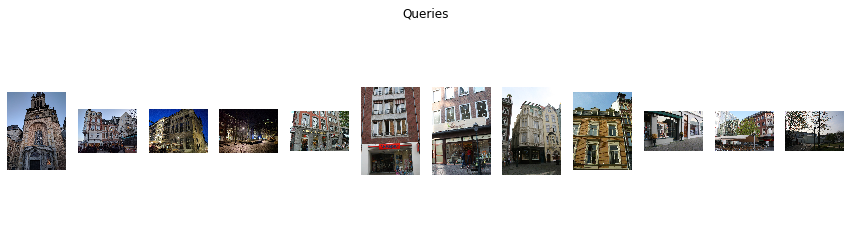

In [156]:
"""
2 day time queries
2 night time queries
2 dataset queries
"""
dataset_queries = [1, 500, 250, 2500, 4000, 576, 2849, 2976]
path_to_queries = [
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_162905.jpg',
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_160713.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_172616.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_191152.jpg',
                   #'data/AachenDayNight/images_upright/db/1.jpg',
                   #'data/AachenDayNight/images_upright/db/500.jpg'
                  ] + ['data/AachenDayNight/images_upright/db/'+str(i)+'.jpg' for i in dataset_queries]
n_queries = len(path_to_queries)
low_res_transform = transforms.Compose([transforms.Resize(global_resolution), transforms.CenterCrop(global_resolution)])
query_imgs_high_res = [load_image(path) for path in path_to_queries]
#query_imgs_low_res = [transform(img) for img in query_imgs_high_res]
fig = plt.figure(figsize=(15,4))
plt.title('Queries')
plt.axis('off')
for i, img in enumerate(query_imgs_high_res):
    a = fig.add_subplot(1, len(query_imgs_high_res), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 1. Find similar images (global descriptors)

In [157]:
model = netvlad.vd16_pitts30k_conv5_3_max_dag(weights_path='data/teacher_models/netvlad_pytorch/vd16_pitts30k_conv5_3_max_dag.pth')
model.eval()
query_global_desc = [model(transforms.ToTensor()(low_res_transform(img)).unsqueeze(0)).detach().cpu().squeeze(0).numpy() for img in query_imgs_high_res]
query_global_desc = np.vstack(query_global_desc)
print(query_global_desc.shape)

(12, 100352)


Global descriptors for dataset are precalculated

In [165]:
print('Loading database global features')
t = time.time()
if augmented:
    global_features_cursor = get_cursor('data/global_features_augmented.db')
else:
    global_features_cursor = get_cursor('data/global_features_low_res.db')
    
global_features = []
image_ids = []
for row in global_features_cursor.execute('SELECT image_id, cols, data FROM global_features;'):
    global_features.append(np.frombuffer(row[2], dtype=np.float32).reshape(-1, row[1]))
    image_ids.append(row[0])
if augmented:    
    for row in global_features_cursor.execute('SELECT image_id, cols, data FROM global_augmented_features;'):
        global_features.append(np.frombuffer(row[2], dtype=np.float32).reshape(-1, row[1]))
        image_ids.append(-row[0])
    
global_features = np.vstack(global_features)
print(global_features.shape)
global_features_cursor.close()
t = time.time() - t
print('%d seconds'%t)

Loading database global features
(8656, 100352)
93 seconds


In [166]:
def __to_unit_torch__(x, cuda):
    if cuda:
        x = torch.from_numpy(x).float().cuda()
    else:
        x = torch.from_numpy(x).float()
    return (x.transpose(0, 1) / torch.norm(x, p=2, dim=1)).transpose(0,1)


def __approx_torch_global__(x,y,n_neighbors):
    cuda = torch.cuda.is_available()
    x = __to_unit_torch__(x, cuda=cuda)
    y = __to_unit_torch__(y, cuda=cuda)
    with torch.no_grad():
        d = 1. - torch.matmul(x, y.transpose(0,1))
        values, indices = torch.topk(d, n_neighbors, dim=1, largest=False, sorted=True)
        return indices.cpu().numpy()
        
def __approx_np_global__(x,y,n_neighbors):
    ##normalize
    #t = time.time()
    x = x.astype(np.float32)/np.linalg.norm(x.astype(np.float32),axis=-1, keepdims=True)
    y = y.astype(np.float32)/np.linalg.norm(y.astype(np.float32),axis=-1, keepdims=True)
    #t = time.time() - t
    #print('Normalization takes {:.2f} s'.format(t))
    #t = time.time()
    d = 1.-np.matmul(x, y.T)
    k = np.argpartition(d, n_neighbors, axis=1)[:,:n_neighbors]
    intm = np.argsort(np.array([d[i, k[i]] for i in range(k.shape[0])]), axis=1)
    k = np.array([k[i,a] for i, a in enumerate(intm)])
    return k

In [167]:
global_neighbor_method = 'approx_cpu' #choices=['LSH', 'exact', 'approx']

In [168]:
t = time.time()
if global_neighbor_method == 'approx':
    indices = __approx_torch_global__(query_global_desc, global_features, n_images+2 if augmented else n_images+1)
    print(indices.shape)
    torch.cuda.empty_cache() 
elif global_neighbor_method == 'approx_cpu':
    indices = __approx_np_global__(query_global_desc, global_features, n_images+2 if augmented else n_images+1)
elif global_neighbor_method == 'LSH':
    buckets = 4
    engine = nearpy.Engine(global_features.shape[1], lshashes=[nearpy.hashes.RandomBinaryProjections('rbp', buckets)],
                          distance = nearpy.distances.EuclideanDistance())
    counts = []
    for i, v in enumerate(global_features):
        engine.store_vector(v, '%d'%i)
        counts.append(engine.candidate_count(v))
    indices = [engine.neighbours(d) for d in query_global_desc]
    indices = np.array([np.array([int(n[1]) for n in nbr])[:n_images+2 if augmented else n_images+1] for nbr in indices])
    counts = np.array(counts)
    print('Candidate count max: {}\nCandidate count min: {}\nCandidate count avg: {}\nCandidate count median: {}'.format(counts.max(), counts.min(), counts.mean(), np.median(counts)))
    print('Optimal: {}'.format(global_features.shape[1]/float(2**buckets)))
elif global_neighbor_method == 'exact':
    print('Find nearest neighbors for queries')
    print('%d data points with %d sized feature vectors'%(global_features.shape[0], global_features.shape[1]))
    nbrs = NearestNeighbors(n_neighbors=n_images+2 if augmented else n_images+1).fit(global_features)
    print('Fitted')
    distances, indices = nbrs.kneighbors(query_global_desc)
    global_features_cursor.close()
t = time.time() - t
print('%d seconds'%t)



18 seconds


In [172]:
## Discard direct neighbors of dataset images (i.e. themselves)
indices_cut = []
for i in range(4):
    indices_cut.append(indices[i,:n_images])
for i in range(4, len(path_to_queries)):
    #indices_cut.append(indices[i,1:n_images+1])
    lst = []
    j = 0
    for idx in indices[i,1:]:
        aug = image_ids[idx] < 0
        ixs = -image_ids[idx] if aug else image_ids[idx]
        if ixs != image_ids[indices[i,0]]:
            lst.append(idx)
            j += 1
        if j >= n_images:
            break
    indices_cut.append(lst)
    #print(len(lst))
indices = np.stack(indices_cut)
print(indices.shape)

50
50
50
50
50
50
50
50
(12, 50)


In [173]:
def calc_neighbor_match(img_idx, neighbor_idx):
    aug = neighbor_idx < 0
    if aug and img_idx == -neighbor_idx: #same images doesn't count
        return 0.0
    oimg = images[img_idx]
    nimg = images[-neighbor_idx if aug else neighbor_idx]

    valid_o = oimg.point3D_ids > 0 
    pt_ids_o = oimg.point3D_ids[valid_o]

    valid_n = nimg.point3D_ids > 0 
    pt_ids_n = nimg.point3D_ids[valid_n]

    shared = np.isin(pt_ids_o, pt_ids_n)
    pt_ids_s = pt_ids_o[shared]
    #print(pt_ids_o.shape[0])
    #print(pt_ids_n.shape[0])
    #print(pt_ids_s.shape[0])
    #print('Images match {:.1f}%'.format(100.0*(pt_ids_s.shape[0]/pt_ids_o.shape[0])))
    return 100.0*(pt_ids_s.shape[0]/min([pt_ids_o.shape[0], pt_ids_n.shape[0]]))

idx = 5
calc_neighbor_match(get_img_id(database_cursor, 'db/'+path_to_queries[idx].split('/')[-1]), image_ids[indices[idx,0]])

67.4739509997184

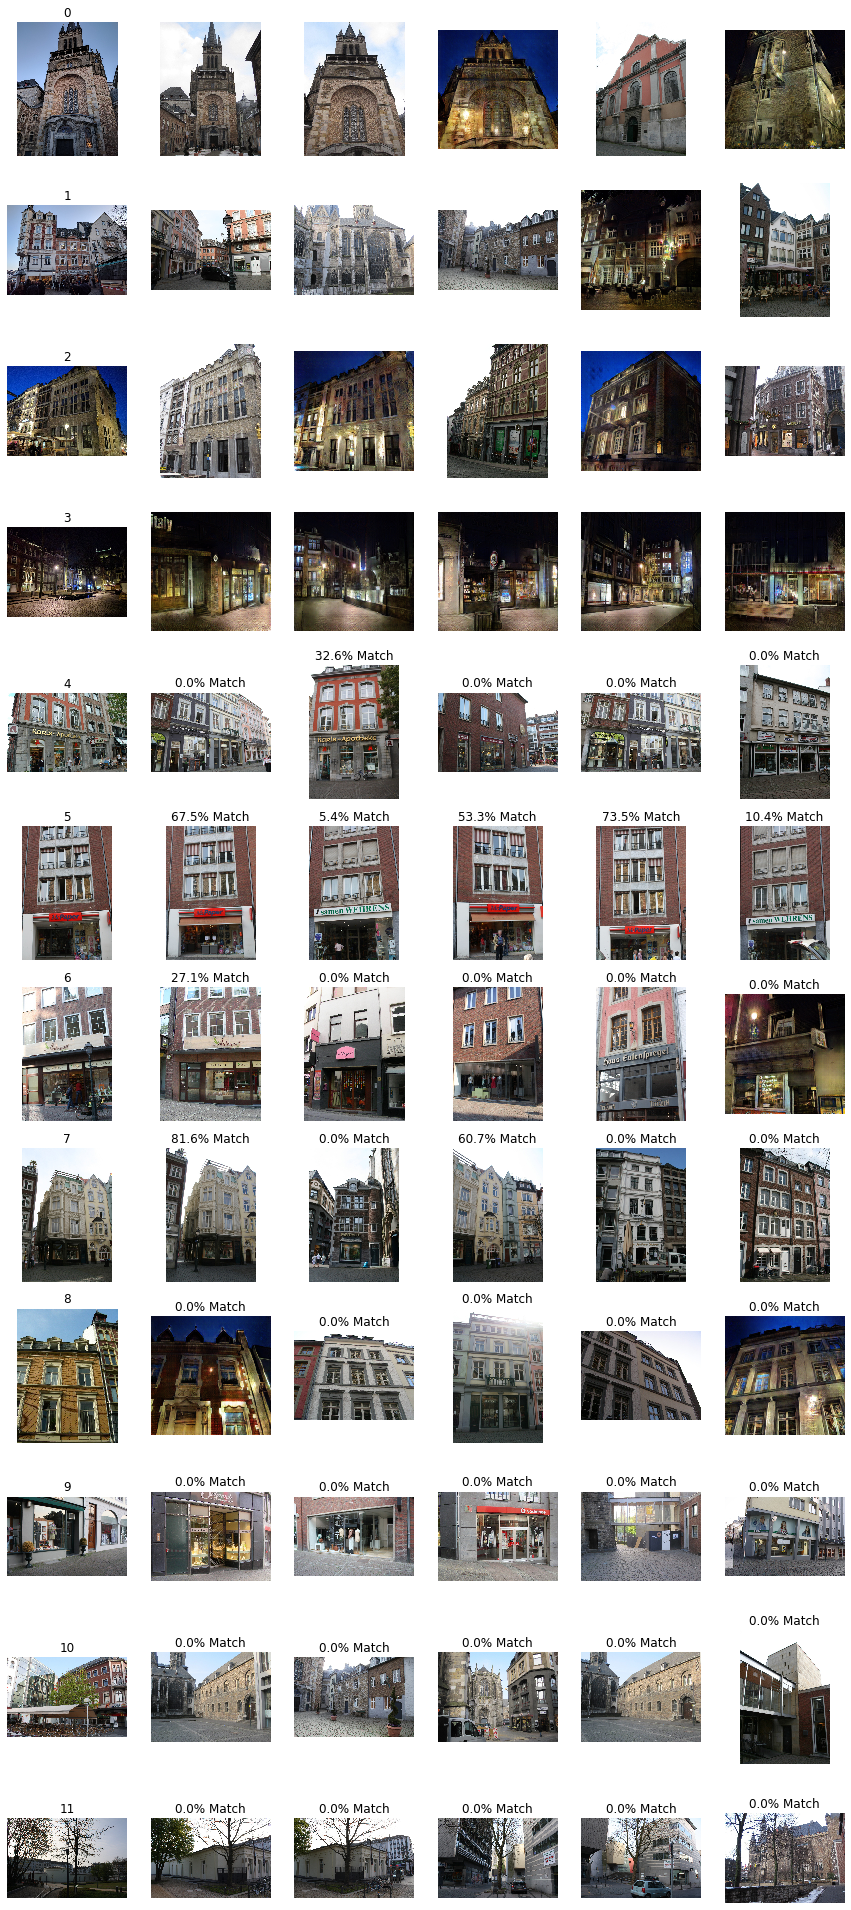

In [174]:
#fig = plt.figure(figsize=(35,15))

max_n = min(5, n_images)

fig = plt.figure(figsize=(15,35))
for i, query_img in enumerate(query_imgs_high_res):
    imgs = [query_img] 
    for n, j in enumerate(indices[i]):
        if n < max_n:
            if j > len(images):
                imgs = imgs + [get_img_augmented(-image_ids[j])]
            else:
                imgs = imgs + [get_img(image_ids[j])]
    #plt.title('Neighbors')
    for j, img in enumerate(imgs):
        # use this to transpose figure
        #ax = fig.add_subplot(n_images+1, n_queries, j*len(query_imgs_high_res)+i+1)
        ax = fig.add_subplot(n_queries, max_n+1, i*(max_n+1)+j+1)
        ax.imshow(img)
        if i >= 4 and j > 0:
            ax.set_title('{:.1f}% Match'.format(calc_neighbor_match(get_img_id(database_cursor, 'db/'+path_to_queries[i].split('/')[-1]), image_ids[indices[i,j-1]])))
        #    plt.title('Neighbor')#'%.0f'%distances[i][j-1])
        elif j == 0:
            ax.set_title(i)
        ax.axis('off')
#fig.savefig('figures/global_neighbors.png', bbox_inches="tight")
plt.show()

In [175]:
for query_id in range(4, len(query_imgs_high_res)):
    query_db_id = get_img_id(database_cursor, 'db/'+path_to_queries[query_id].split('/')[-1])
    found = False
    for i, idx in enumerate(indices[query_id]):
        m = calc_neighbor_match(query_db_id, image_ids[idx])
        #print(m)
        if m > 0.0:
            print('id: {}\tk: {}'.format(query_id, i))
            #plt.imshow(get_img(image_ids[idx]))
            #plt.show()
            found = True
            break
    if not found:
        print('id: {}\tNo match found in {} neighbors'.format(query_id, n_images))
        

id: 4	k: 1
id: 5	k: 0
id: 6	k: 0
id: 7	k: 0
id: 8	k: 20
id: 9	k: 33
id: 10	No match found in 50 neighbors
id: 11	k: 18


In [176]:
t = time.time()
indices_global = __approx_np_global__(global_features[:global_features.shape[0]//2] if augmented else global_features, global_features,global_features.shape[0]//2-1 if augmented else global_features.shape[0]-1)  # cpu version
#indices_global = __approx_torch_global__(global_features[:global_features.shape[0]//2] if augmented else global_features, global_features,global_features.shape[0]//2 if augmented else global_features.shape[0])# gpu version
t = time.time() - t
print('{} seconds'.format(time_to_str(t)))

2 minutes 59 seconds seconds


In [177]:
t = time.time()
nb_lookup = {}
for i, nbs in enumerate(indices_global):
    k = 1
    while k < nbs.shape[0] and calc_neighbor_match(image_ids[i], image_ids[nbs[k]]) <= 1.0:
        k += 1
    #print('id: {}\tk: {}\t Match: {:.1f}'.format(i, k, calc_neighbor_match(image_ids[i], image_ids[indices[i,k]])))
    nb_lookup[i] = k
t = time.time() - t
print('{:.1f} seconds'.format(t))

22.2 seconds


In [178]:
vals = np.array(list(nb_lookup.values()))

In [179]:
def get_correct(vals, k):
    return float(vals[vals <= k].shape[0])/float(vals.shape[0])
k = 50
print('{:.1f}% have correct global neighbor for k={}'.format(100.0*(get_correct(vals, k)), k))

97.5% have correct global neighbor for k=50


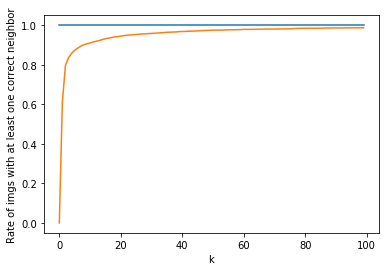

In [180]:
x = np.arange(100)
plt.plot(x, np.ones_like(x))
plt.plot(x, [get_correct(vals, i) for i in x])
plt.xlabel('k')
plt.ylabel('Rate of imgs with at least one correct neighbor')
plt.savefig('figures/global_matching_rate.png')
plt.show()

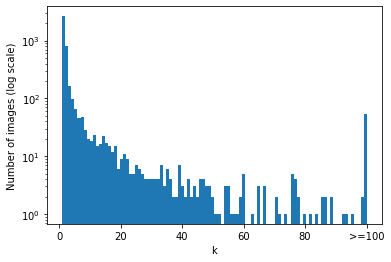

In [181]:
vals_hist = vals.copy()
cut_value = 100
vals_hist[vals_hist > cut_value] = cut_value
fig, ax = plt.subplots()
ax.hist(vals_hist, bins=cut_value, log=True)
ax.set_ylabel('Number of images (log scale)')
ax.set_xlabel('k')
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = '>={}'.format(cut_value)
ax.set_xticklabels(labels)
fig.savefig('figures/k_hist.png')


## 2. Covisibility clustering

In [240]:
query_id = 2

In [241]:
cluster_query = [[abs(image_ids[indices[query_id][i]]) for i in range(n_images)]] ## augmentation currently not supported for local matching
cluster_orig_ids = [image_ids[indices[query_id][0]]]

In [242]:
print('{} images in all cluster'.format(sum([len(i) for i in cluster_query])))

50 images in all cluster


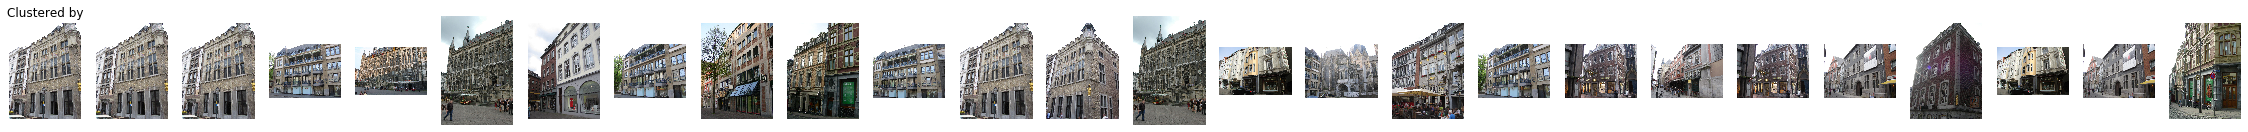

In [243]:
num_imgs_per_cluster = 25
fig = plt.figure(figsize=(40,15))
#plt.title('Covisibility clustering')
#plt.axis('off')
for i, cluster in enumerate(cluster_query):
    imgs = list(cluster)
    ind = np.random.randint(0, len(imgs), num_imgs_per_cluster)
    imgs = np.array(imgs)[ind]
    imgs = [get_img(cluster_orig_ids[i])]+[get_img(j) for j in imgs]
    for j, img in enumerate(imgs):
        a = fig.add_subplot(len(cluster_query), len(imgs), i*len(imgs)+j+1)
        a.imshow(img)
        a.axis('off')
        if j == 0:
            plt.title('Clustered by')
#fig.savefig('figures/cluster.png', bbox_inches="tight")
plt.show()

In [244]:
cluster_points = []
for i, c in enumerate(cluster_query):
    imgs_cluster = list(c)
    points_cluster = set()
    for ind in imgs_cluster:
        pt_ids = images[abs(ind)].point3D_ids
        valid = pt_ids > 0
        points_cluster |= set(pt_ids[valid])
    points_cluster = list(points_cluster)
    cluster_points.append(np.stack([points3d[x].xyz for x in points_cluster]))
    """mask = np.ones(len(points3d),dtype=bool) #np.ones_like(a,dtype=bool)
    mask[points_cluster] = False

    cluster_points.append(points3d[~mask])"""
    print('%d\tpoints in cluster'%cluster_points[i].shape[0])
#other_points = points[mask]
#print('%d other points'%other_points.shape[0])

89461	points in cluster


Median is [ 731.786      2.35635 -151.791  ]


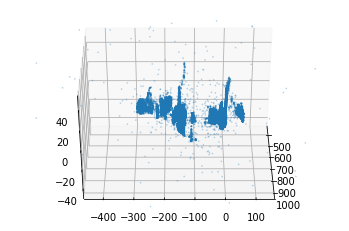

In [245]:
thresh = 300
ax = plt.axes(projection='3d')
#ax.scatter3D(other_points[:,0], other_points[:,2], other_points[:,1], s = 0.5, alpha = 0.01)
for cp in cluster_points:
    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
median = np.sum([np.median(cp, axis=0)*cp.shape[0] for cp in cluster_points], axis=0)/float(sum([cp.shape[0] for cp in cluster_points]))
print('Median is %s'%median)
ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
#plt.savefig('figures/cluster_3d.png', bbox_inches="tight")
plt.show()

## 3. Find local descriptors

<b> Order to get image - keypoint - 3D point correspondances: </b>
1. take image
2. find image name
3. find db_id of image_name
4. get keypoints
5. get valid 3d points

In [246]:
test_id = cluster_orig_ids[0] #197

night/nexus5x/IMG_20161227_172616.jpg


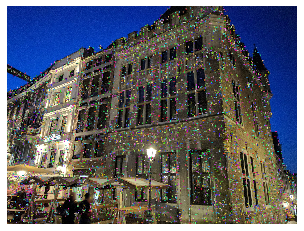

In [247]:
if query_id < 4:
    test_query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/query/', '')
    print(test_query_path)
    query_img_id = get_img_id(query_cursor, test_query_path)
    query_kpts, query_desc_colmap = get_kpts_desc(query_cursor, query_img_id)
else:
    fake_query_path = 'db/'+path_to_queries[query_id].split('/')[-1]
    query_kpts, query_desc_colmap = get_kpts_desc(database_cursor, get_img_id(database_cursor,fake_query_path))
    
query_kpts_colmap = kpts_to_cv(query_kpts)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts_colmap, None)
plt.imshow(query_img)
plt.axis('off')
plt.show()

db/1254.jpg
len kpts: 4763


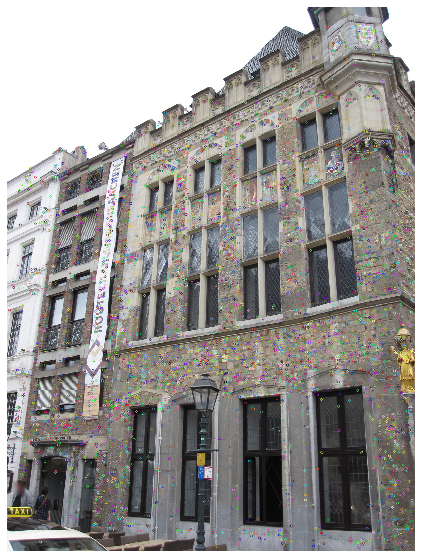

(4763,)
4763
11127
(4763, 128)
(1600, 1200, 3)


In [248]:
db_id = cluster_orig_ids[0]
img_name = images[abs(db_id)].name
if db_id >= 0:
    neighbor_img_original = np.array(load_image('data/AachenDayNight/images_upright/'+img_name))
elif db_id <= 0:
    neighbor_img_original = np.array(load_image('data/AachenDayNight/AugmentedNightImages_v2/'+os.path.split(img_name)[-1].replace('.jpg', '.png')))
print(img_name)
valid = images[abs(db_id)].point3D_ids > 0 
#print([i for i in range(len(valid)) if valid[i]])
neighbor_kpts, neighbor_desc_colmap = get_kpts_desc(database_cursor, abs(db_id))
neighbor_kpts = neighbor_kpts[valid[:neighbor_kpts.shape[0]]] - 0.5
neighbor_kpts_cv = kpts_to_cv(neighbor_kpts)
pt_ids = images[abs(db_id)].point3D_ids[valid]
print('len kpts: %d'%len(neighbor_kpts_cv))
plt.figure(figsize=(10,10))
neighbor_img = cv2.drawKeypoints(neighbor_img_original,neighbor_kpts_cv, None)
plt.imshow(neighbor_img)
plt.axis('off')
plt.show()
neighbor_desc_colmap = neighbor_desc_colmap[valid[:neighbor_desc_colmap.shape[0]]]
#print(images[db_id])
print(pt_ids.shape)
print(len(neighbor_kpts_cv))
print(len(valid)//2)
print(neighbor_desc_colmap.shape)
print(neighbor_img_original.shape)

In [249]:
extractor = superpoint.SuperPointFrontend(weights_path='data/teacher_models/superpoint_v1.pth',
                          nms_dist=4, conf_thresh=0.015, nn_thresh=.7, cuda=torch.cuda.is_available())

In [250]:
def rgb2gray(rgb):
    rgb = np.dot(rgb[...,:3], [0.299, 0.587, 0.144]).astype(np.float32) 
    return rgb / rgb.max()
example_grayscale = rgb2gray(np.array(query_imgs_high_res[query_id]))
print(example_grayscale.shape)
print(example_grayscale.dtype)
print(example_grayscale.max())

(1200, 1600)
float32
1.0


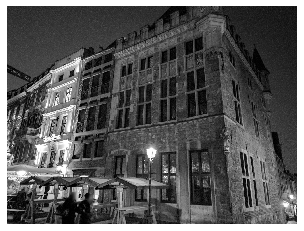

In [251]:
plt.imshow(example_grayscale, cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [252]:
#torch.cuda.empty_cache()  
pts, query_desc_superpoint, heatmap = extractor.run(example_grayscale)
query_desc_superpoint = query_desc_superpoint.T

(3, 3254)
(3254, 256)
(1200, 1600)


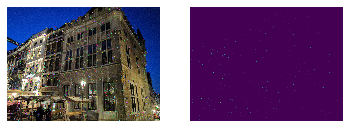

In [253]:
print(pts.shape)  #3xN numpy array with corners [x_i, y_i, confidence_i]^T
print(query_desc_superpoint.shape) #256xN numpy array of corresponding unit normalized descriptors.
print(heatmap.shape)
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
query_kpts_superpoint = kpts_to_cv(pts.T)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts_superpoint, None)
plt.imshow(query_img)
plt.axis('off')
a = fig.add_subplot(1, 2, 2)
plt.imshow(heatmap)
plt.axis('off')
plt.show()

In [254]:
neighbor_img_original_gs = rgb2gray(neighbor_img_original)
_, neighbor_desc_superpoint, heatmap = extractor.run(neighbor_img_original_gs, points=neighbor_kpts)
neighbor_desc_superpoint = neighbor_desc_superpoint.T
print(neighbor_desc_superpoint.shape)

(4763, 256)


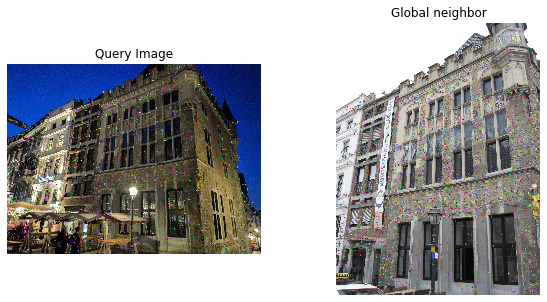

In [255]:
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title('Query Image')
a = fig.add_subplot(1,2,2)
plt.imshow(neighbor_img)
plt.axis('off')
plt.title('Global neighbor')
plt.show()

In [256]:
def __bf_matching__(x, y, ratio_thresh=0.75):
    matcher = cv2.BFMatcher.create(cv2.NORM_L2)
    matches = matcher.knnMatch(y, x, k=2)
    good = []
    for i,(m,n) in enumerate(matches):
        if m.distance < ratio_thresh*n.distance:
            good.append(m)
    matches = np.array([[g.trainIdx, g.queryIdx] for g in good])
    return matches



In [257]:
def __approx_np__(x,y, ratio_thresh=.5):
    ##normalize
    #t = time.time()
    x = x.astype(np.float32)/np.linalg.norm(x.astype(np.float32),axis=-1, keepdims=True)
    y = y.astype(np.float32)/np.linalg.norm(y.astype(np.float32),axis=-1, keepdims=True)
    #t = time.time() - t
    #print('Normalization takes {:.2f} s'.format(t))
    #t = time.time()
    d = 1.-np.matmul(y, x.T)
    k = np.argpartition(d, 2, axis=1)[:,:2]
    #intm = np.argsort(np.array([d[i, ap[i]] for i in range(ap.shape[0])]), axis=1)
    #k = np.array([ap[i,a] for i, a in enumerate(intm)])
    #t = time.time() - t
    #print('Actual calculations take {:.2f} s'.format(t))
    #t = time.time()
    #matches = np.array([[i, k[i,0]] for i in range(d.shape[0]) if d[i, k[i, 0]] < (ratio_thresh**2)*d[i,k[i,1]]])
    #t = time.time() - t
    #print('Matching takes {:.2f} s'.format(t))
    #print(d.shape)
    #print(k.shape)
    #print(matches.shape)
    matches = []
    for i, (m, n) in enumerate(k):
        if d[i,m] < d[i,n]: 
            if d[i, m] < ratio_thresh*d[i, n]:
                matches.append([i, m])
        else:
            if d[i, n] < ratio_thresh*d[i, m]:
                matches.append([i, n])
    return np.array(matches)
    
    
t = time.time()
#matches = __approx_np__(neighbor_desc, query_desc, ratio_thresh=.75)
matches = __approx_np__(query_desc_colmap, neighbor_desc_colmap, ratio_thresh=.75)
t = time.time() - t
print('Took {:.2f} seconds'.format(t))
print(matches.shape)

Took 0.94 seconds
(140, 2)


In [258]:
def __to_unit_torch__(x, cuda):
    if cuda:
        x = torch.from_numpy(x).float().cuda()
    else:
        x = torch.from_numpy(x).float()
    return (x.transpose(0, 1) / torch.norm(x, p=2, dim=1)).transpose(0,1)


def __approx_torch__(x,y,ratio_thresh=.75):
    cuda = torch.cuda.is_available()
    x = __to_unit_torch__(x, cuda=cuda)
    y = __to_unit_torch__(y, cuda=cuda)
    with torch.no_grad():
        d = 1. - torch.matmul(x, y.transpose(0,1))
        values, indices = torch.topk(d, 2, dim=1, largest=False, sorted=True)
        valid = values[:,0] < ratio_thresh**2*values[:,1]
        if not torch.any(valid):
            return np.array([])
        indices_valid = indices[valid][:,0]
        if cuda:
            valid_indices = torch.arange(valid.size()[0]).cuda()[valid]
        else:
            valid_indices = torch.arange(valid.size()[0])[valid]
        ret = torch.stack([torch.Tensor([valid_indices[i], indices_valid[i]]) for i in range(valid_indices.shape[0])])
        return ret.cpu().numpy().astype(np.int64) if cuda else ret.numpy().astype(np.int64)
    """matches = []
    for j, (v,i) in enumerate(zip(values, indices)):
        if v[0] < ratio_thresh*v[1]:
            matches.append([j, i[0]])
    return np.array(matches)
    """
    
t = time.time()
matches = __approx_torch__(neighbor_desc_colmap, query_desc_colmap, ratio_thresh=.75)
t = time.time() - t
print(matches.shape)
print(matches.dtype)
print('Took {:.2f} seconds'.format(t))


(30, 2)
int64
Took 0.04 seconds


In [259]:
matching_type = 'torch_approx' # choices = ['BF', 'torch_approx', 'approx']
method = 'colmap'    # choices = ['colmap', 'superpoint']
ratio_thresh = .75


if method == 'colmap':
    query_desc = query_desc_colmap
    neighbor_desc = neighbor_desc_colmap
    query_kpts = query_kpts_colmap
elif method == 'superpoint':
    query_desc = query_desc_superpoint
    neighbor_desc = neighbor_desc_superpoint
    query_kpts = query_kpts_superpoint
else:
    raise NotImplementedError('Method not implemented')



t = time.time()
print(query_desc.shape)
print(neighbor_desc.shape)
if matching_type == 'BF':
    matches = __bf_matching__(query_desc, neighbor_desc, ratio_thresh=ratio_thresh)
elif matching_type == 'approx':
    matches = __approx_np__(neighbor_desc, query_desc, ratio_thresh=ratio_thresh)
elif matching_type == 'torch_approx':
    matches = __approx_torch__(query_desc, neighbor_desc, ratio_thresh=ratio_thresh)
elif matching_type == 'own':
    matches = own_matching(neighbor_desc, query_desc)
elif matching_type == 'own_threading':
    matches = own_matching_threading(neighbor_desc, query_desc)
elif matching_type == 'pytorch':
    matches = own_matching_pytorch(neighbor_desc, query_desc)
elif matching_type == 'LSH':
    matches = LSH_matching(neighbor_desc, query_desc)
elif matching_type == 'fast':
    q = query_desc.astype(np.float32)   / np.linalg.norm(query_desc.astype(np.float32),    axis=-1, keepdims=True)
    n = neighbor_desc.astype(np.float32)/ np.linalg.norm(neighbor_desc.astype(np.float32), axis=-1, keepdims=True)
    matches = fast_matching(n, q, ratio_thresh=.75)
else:
    raise NotImplementedError('Not Implemented')
print(matches.shape)
matches_to_cv = lambda matches: [cv2.DMatch(_queryIdx=m[1], _trainIdx=m[0], _imgIdx=0, _distance=1.0) for m in matches]
matches_cv = matches_to_cv(matches)
t = time.time() - t
print('Matching took {:.1f} seconds\nFound {} matches'.format(t, len(matches)))

(10464, 128)
(4763, 128)
(62, 2)
Matching took 0.1 seconds
Found 62 matches


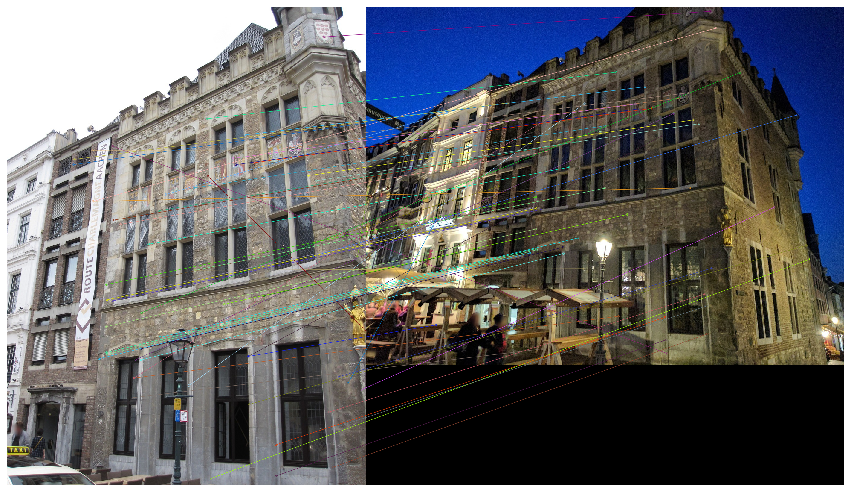

In [260]:
img3 = np.empty((max(query_img.shape[0], neighbor_img.shape[0]), query_img.shape[1] + neighbor_img.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(neighbor_img_original,neighbor_kpts_cv,np.array(query_imgs_high_res[query_id]),query_kpts,matches_cv,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3)
plt.axis('off')
plt.savefig('figures/local_matching_{}_{}.png'.format(matching_type, method), bbox_inches="tight")
plt.show()

In [261]:
if method == 'colmap' and query_id >= 4:
    oimg = images[get_img_id(database_cursor, 'db/'+path_to_queries[query_id].split('/')[-1])]
    nimg = images[image_ids[indices[query_id,0]]]
    #print(oimg)
    #print(nimg)
    
    valid_o = oimg.point3D_ids > 0 
    pt_ids_o = oimg.point3D_ids#[valid_o]
    pt_ids_o = pt_ids_o[:pt_ids_o.shape[0]//2]

    valid_n = nimg.point3D_ids > 0 
    pt_ids_n = nimg.point3D_ids[valid_n]
    
    
    #print(pt_ids_o.shape)
    #print(pt_ids_n.shape)
    
    correct, incorrect = 0,0
    incorrect_matches = []
    for m1, m2 in matches:
        if valid_o[m1]:
            if pt_ids_o[m1] == pt_ids_n[m2]:
                correct += 1
            else:
                incorrect += 1
                incorrect_matches.append([m1, m2])
    incorrect_matches = matches_to_cv(np.array(incorrect_matches))
    print('{} correct / {} incorrect matches ({:.1f}%)'.format(correct, incorrect, 100.0*(correct / float(correct+incorrect))))
    img3 = np.empty((max(query_img.shape[0], neighbor_img.shape[0]), query_img.shape[1] + neighbor_img.shape[1], 3), dtype=np.uint8)
    cv2.drawMatches(neighbor_img_original,neighbor_kpts_cv,np.array(query_imgs_high_res[query_id]),query_kpts,incorrect_matches,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
    plt.figure(figsize=(10,10))
    plt.title('Incorrectly matched')
    plt.imshow(img3)
    plt.axis('off')
    plt.show()

In [275]:
##settings
ratio_thresh = 0.75# 0.75
matching_type = 'approx'
extraction = 'colmap'

if extraction == 'colmap':
    query_desc = query_desc_colmap
elif extraction == 'superpoint':
    query_desc = query_desc_superpoint


t = time.time()
matched_kpts_cv = []
matched_pts = []
correct, incorrect = 0,0
if query_id >= 4 and extraction == 'colmap':
    valid_o = oimg.point3D_ids > 0 
    pt_ids_o = oimg.point3D_ids
    pt_ids_o = pt_ids_o[:pt_ids_o.shape[0]//2]
superpoint_cursor = sqlite3.connect('data/superpoint.db').cursor()
print('Start')
pt_ids_all = []
data_descs = []
for c in cluster_query:
    for img in c:
        db_id = img # get_img_id_dataset(database_cursor, img)
        valid = images[db_id].point3D_ids > 0 
        pt_ids = images[db_id].point3D_ids[valid]
        if extraction == 'colmap':
            data_kpts, data_desc = get_kpts_desc(database_cursor, db_id)
            #data_kpts_cv = kpts_to_cv(data_kpts[valid[:data_kpts.shape[0]]] - 0.5)
            data_desc = data_desc[valid[:data_desc.shape[0]]]
        if extraction == 'superpoint':
            path_to_img = 'data/AachenDayNight/images_upright/'+img_name
            cv_img = cv2.imread(path_to_img, 0).astype(np.float32)/255.0
            data_kpts = keypoints_from_colmap_db(database_cursor, int(img))
            data_kpts = data_kpts[valid[:data_kpts.shape[0]]] - 0.5
            _, data_desc, _ = extractor.run(cv_img, points=data_kpts)
            data_desc = data_desc.T
            #superpoint_cursor.execute('SELECT cols, desc FROM local_features WHERE image_id==?;',(int(db_id),))
            #cols, desc = next(superpoint_cursor)
            #data_desc = np.frombuffer(desc, dtype=np.float32).reshape(cols, 256)
            #except:
            #    print(db_id)
            #    continue
        pt_ids_all.append(pt_ids)
        data_descs.append(data_desc)
                
pt_ids_all = np.concatenate(pt_ids_all)
data_descs = np.vstack(data_descs)

if matching_type == 'BF':
    matches = __bf_matching__(query_desc, data_descs)
elif matching_type == 'approx':
    matches = __approx_np__(data_descs, query_desc)
elif matching_type == 'torch_approx':
    matches = __approx_torch__(query_desc, data_descs)
if query_id >= 4 and extraction == 'colmap':
    for m1, m2 in matches:
        if valid_o[m1]:
            if pt_ids_o[m1] == pt_ids_all[m2]:
                correct += 1
            else:
                incorrect += 1
        
matched_kpts_cv = [query_kpts[m[0]] for m in matches]
matched_pts = [pt_ids_all[m[1]] for m in matches]
        

t = time.time() - t
superpoint_cursor.close()
print('Total matching time: {:.2f} seconds'.format(t))
if correct + incorrect > 0:
    print('{} correct / {} incorrect matches ({:.1f}%)'.format(correct, incorrect, 100.0*(correct / float(correct+incorrect))))

Start
Total matching time: 30.96 seconds


In [276]:
matched_pts_xyz = np.stack([points3d[i].xyz for i in matched_pts])
print(matched_pts_xyz.mean(axis=0))
print(matched_pts_xyz.shape)

[ 716.2515       4.4261948 -175.48318  ]
(10, 3)


In [277]:
matched_keypoints = np.vstack([np.array([x.pt[0], x.pt[1]]) for x in matched_kpts_cv])
print(matched_keypoints.shape)

(10, 2)


## 5. Calculate pose

In [278]:
query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/', '')
cm = camera_matrices[query_path]
camera_matrix = cm['cameraMatrix']
distortion_coeff = cm['rad_dist']
print(camera_matrix)
print(distortion_coeff)

[[1.19991e+03 0.00000e+00 8.00000e+02]
 [0.00000e+00 1.19991e+03 6.00000e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
-0.0324314


In [279]:
n_iter = 1000

In [286]:
t = time.time()
dist_vec = np.array([distortion_coeff, 0, 0, 0])
success, R_vec, translation, inliers = cv2.solvePnPRansac(
        matched_pts_xyz, matched_keypoints, camera_matrix, dist_vec,
        iterationsCount=n_iter, reprojectionError=10.,
        flags=cv2.SOLVEPNP_P3P)
t = time.time() - t
print('PnP RANSAC took %d seconds (%.2f/iteration)'%(t, float(t)/float(n_iter)))

PnP RANSAC took 0 seconds (0.00/iteration)


In [287]:
if success:
    print('Successful matching')
    print(inliers.shape)
else:
    print('Not succesful')
print(R_vec)
print(translation)


Successful matching
(8, 1)
[[ 2.3357129 ]
 [-0.25115526]
 [-1.64899855]]
[[-426.74216682]
 [ 189.58057981]
 [ 588.43158405]]


In [288]:
print(matched_pts_xyz[inliers].shape)
print(matched_keypoints[inliers].shape)

(8, 1, 3)
(8, 1, 2)


In [289]:
min_inliers = 5

if success:
    inliers = inliers[:, 0] if len(inliers.shape) > 1 else inliers
    num_inliers = len(inliers)
    inlier_ratio = len(inliers) / len(matched_keypoints)
    print('{} inliers ({:.1f}%)'.format(num_inliers, 100.0*inlier_ratio))
    success &= num_inliers >= min_inliers

    ret, R_vec, t = cv2.solvePnP(
                matched_pts_xyz[inliers], matched_keypoints[inliers], camera_matrix,
                dist_vec, rvec=R_vec, tvec=translation, useExtrinsicGuess=True,
                flags=cv2.SOLVEPNP_ITERATIVE)
    assert ret

    query_T_w = np.eye(4)
    query_T_w[:3, :3] = cv2.Rodrigues(R_vec)[0]
    query_T_w[:3, 3] = t[:, 0]
    w_T_query = np.linalg.inv(query_T_w)

    #ret = LocResult(success, num_inliers, inlier_ratio, w_T_query)
print('Success') if success else print('Failed')

8 inliers (80.0%)
Success


In [290]:
print(w_T_query)

[[ 3.33743997e-01 -2.99825577e-01 -8.93711121e-01  7.25792242e+02]
 [ 1.63229061e-02 -9.46089665e-01  3.23493291e-01 -7.07446229e-01]
 [-9.42522417e-01 -1.22551907e-01 -3.10857722e-01 -1.93651011e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [291]:
#print(w_T_query)
qvec_nvm = list(Quaternion(matrix=query_T_w)) # rotmat2qvec(w_T_query[:3,:3])
pos = -txq.rotate_vector(w_T_query[:3,3], qvec_nvm)
print('Calculated position: {}\nOrientation: {}'.format(w_T_query[:3, 3], qvec_nvm))
print('Transformed position: {}'.format(pos))
if query_id > 3:
    #pose_stats_filename = os.path.join('data/AachenDayNight/', 'pose_stats.txt')
    #mean_t, std_t = np.loadtxt(pose_stats_filename)
    #position = dataset[dataset_queries[query_id-4]][1][:3]
    #position = position*std_t + mean_t
    position = colmap_image_to_pose(images[get_img_id(database_cursor, fake_query_path)])[:3,3]
    rotation = images[get_img_id(database_cursor, fake_query_path)].qvec
    
    #query_T_w = np.linalg.inv(result.T)
    #pos_nvm = query_T_w[:3, 3].tolist()
    
    error_rot = quaternion_angular_error(rotation, qvec_nvm)
    error = np.linalg.norm(position-w_T_query[:3,3])
    error_str = '%.1f m'%error if error > 1e-1 else '%.1f cm'%(100.0*error)
    print('Groundtruth: \t%s \nError transl.: \t%s\nAngular error: \t%.2f°'%(str(position), error_str, error_rot))


Calculated position: [ 7.25792242e+02 -7.07446229e-01 -1.93651011e+02]
Orientation: [0.1385610073458219, 0.8047812410627427, -0.08806824037720414, -0.5704138728271653]
Transformed position: [-424.73767571  193.20946976  588.67954027]
